In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from config import Config
from utils.visualizer import TradingVisualizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score  

In [2]:
# Add current directory to path
current_dir = Path.cwd()
sys.path.append(str(current_dir))


In [3]:
# Alpaca Functions
def fetch_historical_data(symbol: str, days: int = None) -> pd.DataFrame:
    """        
    Args:
        symbol: Stock symbol (e.g. 'AAPL')
        days: Number of days of historical data to fetch (default: None for max available)
        
    Returns:
        DataFrame with OHLCV data
    """
    
    # Initialize Client
    client = StockHistoricalDataClient(
        api_key=Config.ALPACA_API_KEY,
        secret_key=Config.ALPACA_SECRET_KEY,
    )

    # If days is not provided, use the default number of days from config
    if days is None:
        days = Config.HISTORICAL_DAYS

    # Calculate date range to fetch data for
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    print(f"Date range: {start_date.date()} to {end_date.date()} for {symbol}")


    try:
        # Create request for daily bars
        request_params = StockBarsRequest(
            symbol_or_symbols=symbol,
            timeframe=TimeFrame.Day,
            start=start_date,
            end=end_date
        )
        
        # Fetch data
        bars = client.get_stock_bars(request_params)
        
        # Convert to DataFrame
        df = bars.df
        
        # Reset index to make symbol and timestamp regular columns
        if isinstance(df.index, pd.MultiIndex):
            df = df.reset_index()
        else:
            df = df.reset_index()
        
        # Ensure timestamp column exists and is datetime
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Sort by timestamp
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        print(f"Successfully fetched {len(df)} trading days of data")
        print(f"Data columns: {df.columns.tolist()}")
        
        return df
        
    except Exception as e:
        raise Exception(f"Error with Alpaca API (Check API Keys and Base URL): {str(e)}")


def get_latest_price(symbol: str) -> float:
    """        
    Args:
        symbol: Stock ticker symbol
        
    Returns: Latest closing price
    """
    df = fetch_historical_data(symbol, days=5)
    return df.iloc[-1]['close']

# Features

### Basic Price Features
Percentage change in price [Capture short term price movement and direction]
Log of price rations       [Symmetric and stable, may prove useful]

### Volatility Features
Rolling standard deviation of returns over  5 and 10 days [Shows risk factors clearly]

### Volume Features
Percentage change in trading volume [To indicate price movement and seperation from volatility]
5 day average volume                [To identify volume spikes]
Volume relative to average          [Normalizes volume across time](Consider removing this, might lead to unnessary trees)

### Simple Moving Average
5, 10, 20 day moving averages [smoothes the noise in the data to uncover underlying trends](Have several for different trends)

### Price Relative to Moving Average
Price divided by moving average [Normalize position relative to trend]
value > 1 means above average (overbought, expect to drop)
value < 1 means below average (oversold, expect to rise)

### Moving Average Crossover
difference between 5 day and 10 day SMA  [Golden/death cross]
diff between 10 day and 20 day SMA

Golden death cross is a signal that indicates prediction of bullish or bearish future trends
Positive = short term above long term (Bullish)
Negative = short temr under long term (Bearish)
this might be something that the Random Forest might need more guidance to properly use

There are also some other key trends that depict markets, I can't remember rn, but there is one specific one that has no mathematical expectation, but returns are very favorable for long term investments (!TODO)

### Momentum Features
Price Change over 5 and 10 days [Measure upward and downward trend strength]

### Price Range Features
Daily price range (Highest value - Lowest Value before close)
Position of high candle when closed   
Position of low candle when closed 

if close_to_high is near 1 [Means strong buying pressure](Might be kinda redundant considering we have SMA, conisder removing SMA)
if close_to_low is near 1  [Means strong selling pressure]







In [4]:
# FEATURE ENGINEERING
# Create technical features from OHLCV data
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """        
    Args:
        df: DataFrame with columns: open, high, low, close, volume, timestamp
        
    Returns: DataFrame with additional feature columns
    """
    df = df.copy()
    
    # Basic price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Volatility (rolling standard deviation of returns)
    df['volatility_5'] = df['returns'].rolling(window=5).std()
    df['volatility_10'] = df['returns'].rolling(window=10).std()
    
    # Volume features
    df['volume_change'] = df['volume'].pct_change()
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_5']
    
    # Simple Moving Averages (SMA)
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    
    # Price relative to moving averages
    df['price_to_sma_5'] = df['close'] / df['sma_5']
    df['price_to_sma_10'] = df['close'] / df['sma_10']
    df['price_to_sma_20'] = df['close'] / df['sma_20']
    
    # Moving average crossovers (signals)
    df['sma_5_10_cross'] = df['sma_5'] - df['sma_10']
    df['sma_10_20_cross'] = df['sma_10'] - df['sma_20']
    
    # Momentum
    df['momentum_5'] = df['close'] - df['close'].shift(5)
    df['momentum_10'] = df['close'] - df['close'].shift(10)
    
    # Price range features
    df['high_low_range'] = df['high'] - df['low']
    df['close_to_high'] = (df['high'] - df['close']) / df['high_low_range']
    df['close_to_low'] = (df['close'] - df['low']) / df['high_low_range']
    
    return df

In [5]:
# TARGET VARIABLE CREATION
def create_target(df: pd.DataFrame, forward_days: int = 5, threshold: float = 0.02) -> pd.DataFrame:
    """        
    Target classes:
    - 0 (sell): Future return < -threshold
    - 1 (hold): Future return between -threshold and +threshold
    - 2 (buy): Future return > +threshold
    
    Args:
        df: DataFrame with price data
        forward_days: Number of days to look forward for target calculation
        threshold: Percentage threshold for buy/sell signals (e.g., 0.02 = 2%)
        
    Returns:
        DataFrame with 'target' column added
    """
    df = df.copy()
    
    # Calculate forward returns
    df['forward_returns'] = df['close'].shift(-forward_days) / df['close'] - 1
    
    # Create target based on forward returns
    df['target'] = 1                                                # Default to HOLD
    df.loc[df['forward_returns'] > threshold, 'target'] = 2    # BUY
    df.loc[df['forward_returns'] < -threshold, 'target'] = 0   # Sell
    
    return df

In [6]:
# FEATURE ENGINEERING PIPELINE
def prepare_data(df: pd.DataFrame, include_target: bool = True, forward_days: int = 5, threshold: float = 0.02) -> pd.DataFrame:
    """        
    Args:
        df: Raw OHLCV DataFrame
        include_target: Whether to create target variable (False for prediction)
        forward_days: Number of days to look forward for target calculation
        threshold: Percentage threshold for buy/sell signals (e.g., 0.02 = 2%)
        
    Returns:
        DataFrame with all features and optionally target
    """
    # Create features
    df = create_features(df)
    
    # Create target if requested
    if include_target:
        df = create_target(df, forward_days=forward_days, threshold=threshold)
    
    # Drop rows with NaN values (from rolling calculations)
    df = df.dropna()
    
    return df

In [7]:
def get_feature_columns() -> list:
    """
    Get list of feature column names (excluding target and original OHLCV).
    
    Returns:
        List of feature column names
    """
    return [
        'returns', 'log_returns',
        'volatility_5', 'volatility_10',
        'volume_change', 'volume_ratio',
        'price_to_sma_5', 'price_to_sma_10', 'price_to_sma_20',
        'sma_5_10_cross', 'sma_10_20_cross',
        'momentum_5', 'momentum_10',
        'close_to_high', 'close_to_low'
    ]

In [8]:
# CELL: Model Functions
def train_random_forest(X: pd.DataFrame, y: pd.Series, n_estimators: int = 100, max_depth: int = 10):
    """
    Train a Random Forest model.
    Returns: (model, scaler)
    """
    print(f"\nTraining Random Forest model...")
    print(f"Training samples: {len(X)}")
    print(f"Features: {X.shape[1]}")
    
    # Initialize scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        class_weight='balanced'
    )
    
    # Train
    model.fit(X_scaled, y)
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head().to_string(index=False))
    
    return model, scaler

def predict_signals(model, scaler, X: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Make predictions and get confidence scores.
    Returns: (predictions, confidence)
    """
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Predict
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)
    confidence = np.max(probabilities, axis=1)
    
    return predictions, confidence

def get_action_name(prediction: int) -> str:
    """Convert numeric prediction to action name."""
    action_map = {0: 'SELL', 1: 'HOLD', 2: 'BUY'}
    return action_map.get(prediction, 'UNKNOWN')

In [9]:
# UTILITIES
def print_header(title: str):
    # Print a formatted section header
    print("\\n" + "=" * 70)
    print(f"  {title}")
    print("=" * 70)

# !TODO THIS WAS MODIFIED
# Display Prediction Results
def display_prediction_results(model, scaler, X_latest, symbol: str, latest_price: float):
    """
    Args:
        model: Trained model instance (RandomForestClassifier)
        scaler: Fitted StandardScaler instance
        X_latest: Features for the latest data point
        symbol: Stock symbol
        latest_price: Current stock price
    """

    print_header("PREDICTION RESULTS")

    # Make prediction using the predict_signals function
    predictions, confidence_scores = predict_signals(model, scaler, X_latest)
    prediction = predictions[0]
    confidence = confidence_scores[0]
    action = get_action_name(prediction)
    
    # Display results
    print(f"\nStock: {symbol}")
    print(f"Current Price: ${latest_price:.2f}")
    print(f"Model: Random Forest")
    print(f"\nRECOMMENDATION: {action}")
    print(f"Confidence: {confidence:.2%}")
    
    # Display confidence interpretation
    if confidence >= Config.CONFIDENCE_THRESHOLD:
        confidence_level = "HIGH"
    elif confidence >= 0.4:
        confidence_level = "MEDIUM"
    else:
        confidence_level = "LOW"
    
    print(f"Confidence Level: {confidence_level}")
    
    # Display class probabilities
    X_scaled = scaler.transform(X_latest)
    probabilities = model.predict_proba(X_scaled)[0]
    print("\nClass Probabilities:")
    print(f"  SELL: {probabilities[0]:.2%}")
    print(f"  HOLD: {probabilities[1]:.2%}")
    print(f"  BUY:  {probabilities[2]:.2%}")
    
    # Trading decision
    print("\n" + "-" * 70)
    if confidence >= Config.CONFIDENCE_THRESHOLD:
        print(f"✓ Trading signal: {action} (Confidence meets threshold)")
    else:
        print(f"✗ Trading signal: HOLD (Confidence below threshold of {Config.CONFIDENCE_THRESHOLD:.0%})")
    print("-" * 70)

In [10]:
Config.display()

CONFIGURATION
Alpaca Base URL: https://paper-api.alpaca.markets
API Key: PKZNR4HY...
Trading Enabled: False
Confidence Threshold: 0.3
Default Symbol: AAPL
Historical Days: 365


In [11]:
# 1. DATA ACQUISITION

symbol = Config.DEFAULT_SYMBOL
print(f"Fetching data for {symbol}...")
df = fetch_historical_data(symbol)


print(f"Shape: {df.shape}")
print("___________________________")
print(df.head())

Fetching data for AAPL...
Date range: 2024-11-27 to 2025-11-27 for AAPL


Successfully fetched 249 trading days of data
Data columns: ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']
Shape: (249, 9)
___________________________
  symbol                 timestamp     open    high     low   close  \
0   AAPL 2024-11-29 05:00:00+00:00  234.805  237.81  233.97  237.33   
1   AAPL 2024-12-02 05:00:00+00:00  237.270  240.79  237.16  239.59   
2   AAPL 2024-12-03 05:00:00+00:00  239.810  242.76  238.90  242.65   
3   AAPL 2024-12-04 05:00:00+00:00  242.870  244.11  241.25  243.01   
4   AAPL 2024-12-05 05:00:00+00:00  243.990  244.54  242.13  243.04   

       volume  trade_count        vwap  
0  28481377.0     268955.0  236.570409  
1  48137103.0     469685.0  239.520954  
2  38861017.0     419384.0  241.628776  
3  44383935.0     406663.0  242.952411  
4  40033878.0     401262.0  243.055000  


In [12]:
# 2. FEATURE ENGINEERING
print_header("2. FEATURE ENGINEERING")
df_processed = prepare_data(df)

print("Data prepared successfully.")
print(f"Shape: {df_processed.shape}")

\n======================================================================
  2. FEATURE ENGINEERING
Data prepared successfully.
Shape: (225, 31)


In [13]:
# 3. DATA SPLITTING & MODEL TRAINING
print_header("3. MODEL TRAINING")

feature_cols = get_feature_columns()

# Split: use most data for training, keep last 20% (approx) for testing
# IMPORTANT: We exclude the last 5 days from training/testing because we don't have targets for them yet 
# (since target looks 5 days forward)
train_size = int(len(df_processed) * 0.8)

# Training Data
X_train = df_processed[feature_cols].iloc[:train_size]
y_train = df_processed['target'].iloc[:train_size]

# Testing Data (excluding the very recent 'forward_days' rows which may not have valid targets if recently fetched)
# Using :-5 to be safe with the target window
X_test = df_processed[feature_cols].iloc[train_size:-5]
y_test = df_processed['target'].iloc[train_size:-5]

\n======================================================================
  3. MODEL TRAINING


In [14]:

# Train Model
model, scaler = train_random_forest(X_train, y_train)


Training Random Forest model...
Training samples: 180
Features: 15

Top 5 Most Important Features:
        feature  importance
 sma_5_10_cross    0.096829
  volatility_10    0.087314
price_to_sma_20    0.079609
     momentum_5    0.074627
    momentum_10    0.073856


In [15]:

# 4. EVALUATION
print_header("4. MODEL EVALUATION")

# Predictions on Test Set
test_predictions, test_confidence = predict_signals(model, scaler, X_test)

# Calculate Metrics
accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Set Accuracy: {accuracy:.2%}")

# Class-wise metrics
for cls, name in zip([0, 1, 2], ['SELL', 'HOLD', 'BUY']):
    mask = y_test == cls
    if mask.sum() > 0:
        cls_acc = accuracy_score(y_test[mask], test_predictions[mask])
        print(f"{name} Accuracy: {cls_acc:.2%} ({mask.sum()} samples)")


\n======================================================================
  4. MODEL EVALUATION
Test Set Accuracy: 35.00%
SELL Accuracy: 0.00% (6 samples)
HOLD Accuracy: 66.67% (21 samples)
BUY Accuracy: 0.00% (13 samples)


\n======================================================================
  5. VISUALIZATION


c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\utils\visualizer.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Visualization saved: c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\assets\images\AAPL_Random_Forest_20251127_223729.png
✓ Report saved: c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\assets\images\AAPL_Random_Forest_report_20251127_223730.txt

Visualization files created in: c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\assets\images
\n======================================================================
  PREDICTION RESULTS

Stock: AAPL
Current Price: $277.55
Model: Random Forest

RECOMMENDATION: SELL
Confidence: 35.35%
Confidence Level: HIGH

Class Probabilities:
  SELL: 35.35%
  HOLD: 31.64%
  BUY:  33.01%

-------------------------------------------------

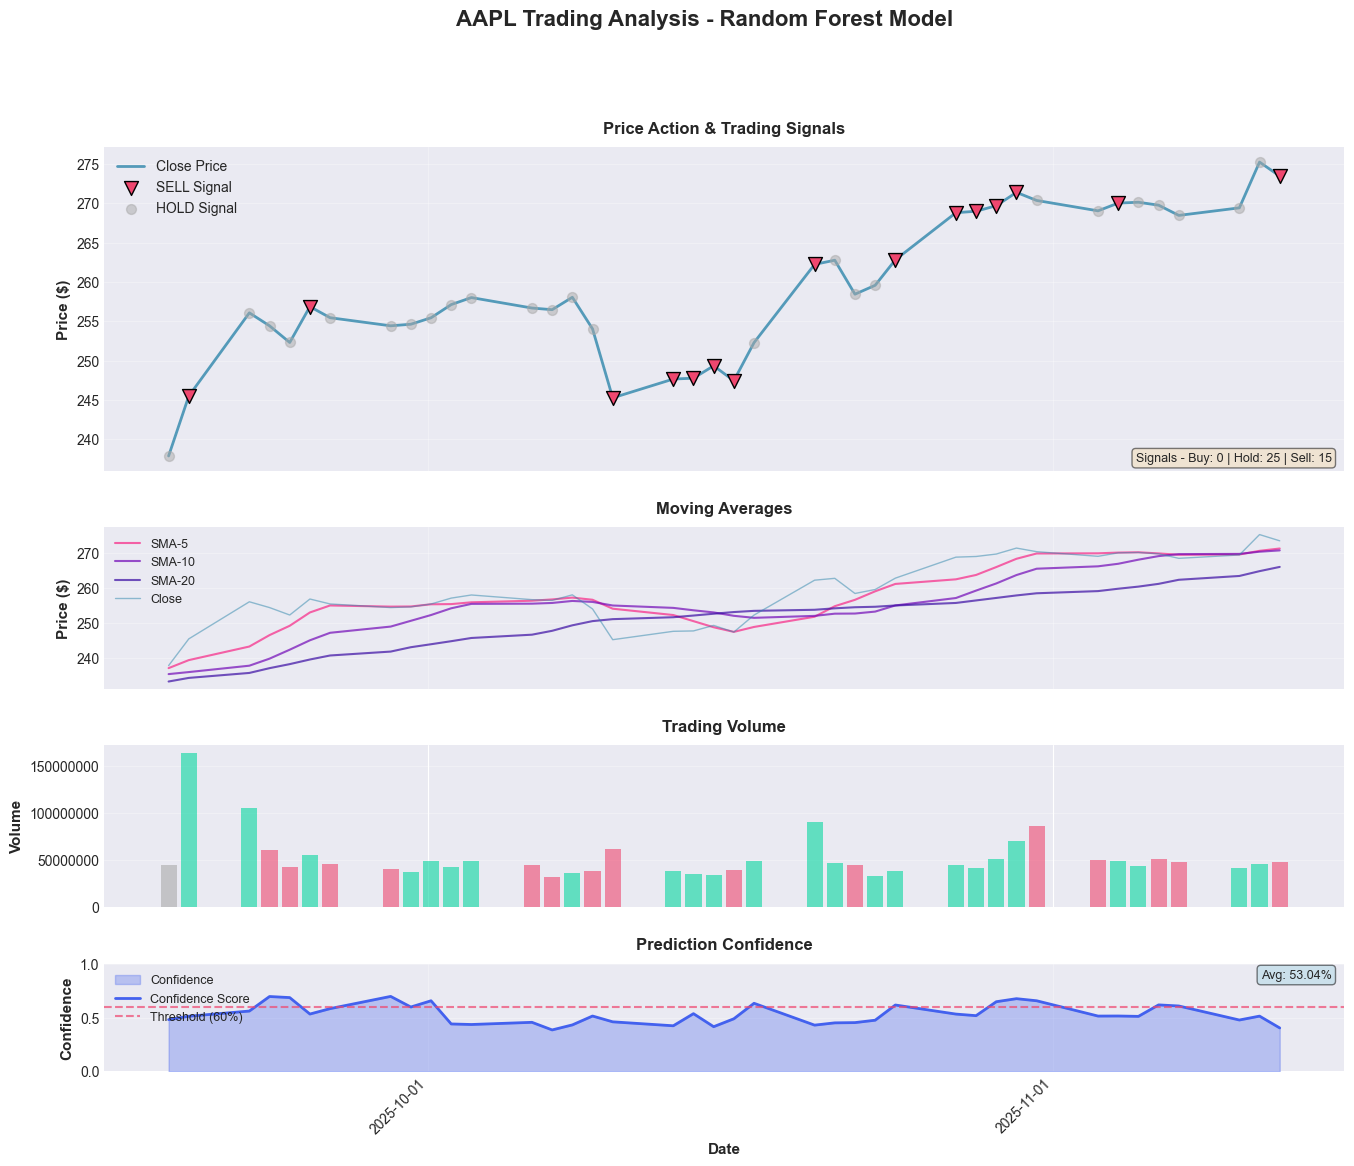

In [16]:

# 5. VISUALIZATION
print_header("5. VISUALIZATION")

# We pass a simple object with a 'name' attribute to satisfy the visualizer's interface
# or just pass the string "Random Forest" if we modify the visualizer call.
# Creating a dummy object to mimic the model class structure expected by visualizer
class ModelWrapper:
    def __init__(self, name): self.name = name

wrapper_model = ModelWrapper("Random Forest")

visualizer = TradingVisualizer()

# Get corresponding data for visualization (need dates/prices, not just features)
viz_df = df_processed.iloc[train_size:-5].copy()

viz_path = visualizer.plot_trading_signals(
    df=viz_df,
    predictions=test_predictions,
    confidence=test_confidence,
    model_name="Random Forest",
    symbol=symbol,
    feature_cols=feature_cols
)

# Create summary report
metrics = {'overall_accuracy': accuracy, 'num_samples': len(y_test)}
report_path = visualizer.create_summary_report(
    df=viz_df,
    predictions=test_predictions,
    confidence=test_confidence,
    model_name="Random Forest",
    symbol=symbol,
    test_metrics=metrics
)

print(f"\nVisualization files created in: {visualizer.output_dir}")

# 6. LATEST PREDICTION
# Use the most recent data point available
latest_features = df_processed[feature_cols].tail(1)
latest_close = df['close'].iloc[-1]

display_prediction_results(model, scaler, latest_features, symbol, latest_close)

In [28]:
# Diagnostic: Check confidence scores
print_header("CONFIDENCE SCORE ANALYSIS")
print(f"\nConfidence Threshold: {Config.CONFIDENCE_THRESHOLD:.2%}")
print(f"Total predictions: {len(test_confidence)}")
print(f"Predictions above threshold: {(test_confidence >= Config.CONFIDENCE_THRESHOLD).sum()}")
print(f"Predictions below threshold: {(test_confidence < Config.CONFIDENCE_THRESHOLD).sum()}")
print(f"\nConfidence Statistics:")
print(f"  Mean:   {test_confidence.mean():.2%}")
print(f"  Median: {np.median(test_confidence):.2%}")
print(f"  Min:    {test_confidence.min():.2%}")
print(f"  Max:    {test_confidence.max():.2%}")
print(f"\nPrediction Distribution:")
print(f"  BUY signals:  {(test_predictions == 2).sum()}")
print(f"  HOLD signals: {(test_predictions == 1).sum()}")
print(f"  SELL signals: {(test_predictions == 0).sum()}")

\n======================================================================
  CONFIDENCE SCORE ANALYSIS

Confidence Threshold: 30.00%
Total predictions: 40
Predictions above threshold: 40
Predictions below threshold: 0

Confidence Statistics:
  Mean:   53.04%
  Median: 51.36%
  Min:    38.48%
  Max:    69.59%

Prediction Distribution:
  BUY signals:  0
  HOLD signals: 25
  SELL signals: 15


In [35]:
# Diagnostic: Check target distribution
print_header("TARGET DISTRIBUTION ANALYSIS")

print("\nTraining Set:")
print(f"  BUY (2):  {(y_train == 2).sum()} ({(y_train == 2).sum()/len(y_train)*100:.1f}%)")
print(f"  HOLD (1): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"  SELL (0): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")

print("\nTest Set:")
print(f"  BUY (2):  {(y_test == 2).sum()} ({(y_test == 2).sum()/len(y_test)*100:.1f}%)")
print(f"  HOLD (1): {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")
print(f"  SELL (0): {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")

# Check forward returns distribution
print("\nForward Returns Statistics (5-day):")
forward_returns = df_processed['forward_returns'].dropna()
print(f"  Mean:   {forward_returns.mean():.4f} ({forward_returns.mean()*100:.2f}%)")
print(f"  Median: {forward_returns.median():.4f} ({forward_returns.median()*100:.2f}%)")
print(f"  Std:    {forward_returns.std():.4f} ({forward_returns.std()*100:.2f}%)")
print(f"  Min:    {forward_returns.min():.4f} ({forward_returns.min()*100:.2f}%)")
print(f"  Max:    {forward_returns.max():.4f} ({forward_returns.max()*100:.2f}%)")
print(f"\n  Returns > 2%:  {(forward_returns > 0.02).sum()} ({(forward_returns > 0.02).sum()/len(forward_returns)*100:.1f}%)")
print(f"  Returns < -2%: {(forward_returns < -0.02).sum()} ({(forward_returns < -0.02).sum()/len(forward_returns)*100:.1f}%)")

\n======================================================================
  TARGET DISTRIBUTION ANALYSIS

Training Set:
  BUY (2):  59 (32.8%)
  HOLD (1): 65 (36.1%)
  SELL (0): 56 (31.1%)

Test Set:
  BUY (2):  13 (32.5%)
  HOLD (1): 21 (52.5%)
  SELL (0): 6 (15.0%)

Forward Returns Statistics (5-day):
  Mean:   0.0033 (0.33%)
  Median: 0.0016 (0.16%)
  Std:    0.0491 (4.91%)
  Min:    -0.2275 (-22.75%)
  Max:    0.1724 (17.24%)

  Returns > 2%:  75 (33.3%)
  Returns < -2%: 63 (28.0%)


In [36]:
# Compare predictions to actual targets
print_header("PREDICTION vs ACTUAL ANALYSIS")

from sklearn.metrics import confusion_matrix, classification_report

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_predictions)
print("                Predicted")
print("              SELL  HOLD  BUY")
print(f"Actual SELL   {cm[0][0]:4d}  {cm[0][1]:4d}  {cm[0][2]:4d}")
print(f"       HOLD   {cm[1][0]:4d}  {cm[1][1]:4d}  {cm[1][2]:4d}")
print(f"       BUY    {cm[2][0]:4d}  {cm[2][1]:4d}  {cm[2][2]:4d}")

print("\nClassification Report:")
print(classification_report(y_test, test_predictions, target_names=['SELL', 'HOLD', 'BUY']))

\n======================================================================
  PREDICTION vs ACTUAL ANALYSIS

Confusion Matrix:
                Predicted
              SELL  HOLD  BUY
Actual SELL      0     6     0
       HOLD      7    14     0
       BUY       8     5     0

Classification Report:
              precision    recall  f1-score   support

        SELL       0.00      0.00      0.00         6
        HOLD       0.56      0.67      0.61        21
         BUY       0.00      0.00      0.00        13

    accuracy                           0.35        40
   macro avg       0.19      0.22      0.20        40
weighted avg       0.29      0.35      0.32        40



c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Rec

In [ ]:
# Diagnostic: Check target distribution
print_header("TARGET DISTRIBUTION ANALYSIS")

print("\nTraining Set:")
print(f"  BUY (2):  {(y_train == 2).sum()} ({(y_train == 2).sum()/len(y_train)*100:.1f}%)")
print(f"  HOLD (1): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"  SELL (0): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")

print("\nTest Set:")
print(f"  BUY (2):  {(y_test == 2).sum()} ({(y_test == 2).sum()/len(y_test)*100:.1f}%)")
print(f"  HOLD (1): {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")
print(f"  SELL (0): {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")

# Check forward returns distribution
print("\nForward Returns Statistics (5-day):")
forward_returns = df_processed['forward_returns'].dropna()
print(f"  Mean:   {forward_returns.mean():.4f} ({forward_returns.mean()*100:.2f}%)")
print(f"  Median: {forward_returns.median():.4f} ({forward_returns.median()*100:.2f}%)")
print(f"  Std:    {forward_returns.std():.4f} ({forward_returns.std()*100:.2f}%)")
print(f"  Min:    {forward_returns.min():.4f} ({forward_returns.min()*100:.2f}%)")
print(f"  Max:    {forward_returns.max():.4f} ({forward_returns.max()*100:.2f}%)")
print(f"\n  Returns > 2%:  {(forward_returns > 0.02).sum()} ({(forward_returns > 0.02).sum()/len(forward_returns)*100:.1f}%)")
print(f"  Returns < -2%: {(forward_returns < -0.02).sum()} ({(forward_returns < -0.02).sum()/len(forward_returns)*100:.1f}%)")

In [33]:
# Backtesting Function
def backtest_strategy(
    df: pd.DataFrame, 
    predictions: np.ndarray, 
    confidence: np.ndarray,
    initial_capital: float = 10000,
    confidence_threshold: float = 0.00
) -> dict:
    """
    Simulate trading based on predictions and track portfolio performance.
    
    Args:
        df: DataFrame with OHLCV data (must have 'close' column)
        predictions: Array of predictions (0=SELL, 1=HOLD, 2=BUY)
        confidence: Array of confidence scores
        initial_capital: Starting cash amount
        confidence_threshold: Minimum confidence to execute trades (uses Config if None)
        
    Returns:
        Dictionary with performance metrics
    """
    if confidence_threshold is None:
        confidence_threshold = Config.CONFIDENCE_THRESHOLD
    
    cash = initial_capital
    shares = 0
    trades = []
    portfolio_values = []
    
    # Ensure we have the same length
    min_len = min(len(df), len(predictions), len(confidence))
    
    for i in range(min_len):
        current_price = df.iloc[i]['close']
        pred = predictions[i]
        conf = confidence[i]
        
        # Only trade if confidence meets threshold
        if conf >= confidence_threshold:
            if pred == 2:  # BUY
                if cash > 0:
                    # Buy with all available cash
                    shares_to_buy = cash / current_price
                    shares += shares_to_buy
                    cash = 0
                    trades.append({
                        'date': df.iloc[i].get('timestamp', i),
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'confidence': conf
                    })
            
            elif pred == 0:  # SELL
                if shares > 0:
                    # Sell all shares
                    cash = shares * current_price
                    trades.append({
                        'date': df.iloc[i].get('timestamp', i),
                        'action': 'SELL',
                        'price': current_price,
                        'shares': shares,
                        'confidence': conf
                    })
                    shares = 0
        
        # Calculate portfolio value at each step
        portfolio_value = cash + shares * current_price
        portfolio_values.append(portfolio_value)
    
    # Final portfolio value
    final_value = cash + shares * df.iloc[-1]['close']
    total_return = final_value - initial_capital
    return_pct = (total_return / initial_capital) * 100
    
    # Buy and hold baseline for comparison
    buy_hold_shares = initial_capital / df.iloc[0]['close']
    buy_hold_value = buy_hold_shares * df.iloc[-1]['close']
    buy_hold_return = buy_hold_value - initial_capital
    buy_hold_return_pct = (buy_hold_return / initial_capital) * 100
    
    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'return_pct': return_pct,
        'num_trades': len(trades),
        'trades': trades,
        'portfolio_values': portfolio_values,
        'buy_hold_value': buy_hold_value,
        'buy_hold_return': buy_hold_return,
        'buy_hold_return_pct': buy_hold_return_pct
    }

def display_backtest_results(results: dict, symbol: str):
    """Display backtesting results in a formatted way."""
    print_header("BACKTESTING RESULTS")
    
    print(f"\nStock: {symbol}")
    print(f"\n{'='*70}")
    print("PORTFOLIO PERFORMANCE")
    print(f"{'='*70}")
    print(f"Starting Capital:    ${results['initial_capital']:,.2f}")
    print(f"Final Portfolio Value: ${results['final_value']:,.2f}")
    print(f"Total Return:        ${results['total_return']:,.2f}")
    print(f"Return Percentage:    {results['return_pct']:+.2f}%")
    
    print(f"\n{'='*70}")
    print("BUY & HOLD COMPARISON")
    print(f"{'='*70}")
    print(f"Buy & Hold Value:    ${results['buy_hold_value']:,.2f}")
    print(f"Buy & Hold Return:   ${results['buy_hold_return']:,.2f}")
    print(f"Buy & Hold Return %: {results['buy_hold_return_pct']:+.2f}%")
    
    print(f"\n{'='*70}")
    print("TRADING STATISTICS")
    print(f"{'='*70}")
    print(f"Total Trades Executed: {results['num_trades']}")
    
    if results['num_trades'] == 0:
        print("\n⚠️  NO TRADES EXECUTED")
        print("Possible reasons:")
        print("  - No BUY signals to purchase shares")
        print("  - SELL signals occurred but no shares were held")
        print("  - All signals were HOLD (no action)")
        print("\nThis suggests the model is very conservative or")
        print("the test period had no clear buying opportunities.")
    
    if results['num_trades'] > 0:
        buy_trades = [t for t in results['trades'] if t['action'] == 'BUY']
        sell_trades = [t for t in results['trades'] if t['action'] == 'SELL']
        print(f"  BUY trades:  {len(buy_trades)}")
        print(f"  SELL trades: {len(sell_trades)}")
        
        if len(buy_trades) > 0:
            avg_buy_conf = np.mean([t['confidence'] for t in buy_trades])
            print(f"  Avg BUY confidence:  {avg_buy_conf:.2%}")
        if len(sell_trades) > 0:
            avg_sell_conf = np.mean([t['confidence'] for t in sell_trades])
            print(f"  Avg SELL confidence: {avg_sell_conf:.2%}")
    
    print(f"\n{'='*70}")
    print("PERFORMANCE COMPARISON")
    print(f"{'='*70}")
    strategy_vs_buyhold = results['return_pct'] - results['buy_hold_return_pct']
    if strategy_vs_buyhold > 0:
        print(f"✓ Strategy outperformed Buy & Hold by {strategy_vs_buyhold:.2f}%")
    else:
        print(f"✗ Strategy underperformed Buy & Hold by {abs(strategy_vs_buyhold):.2f}%")
    print(f"{'='*70}\n")

In [34]:
# 7. BACKTESTING
print_header("7. BACKTESTING")

# Run backtest on test set
backtest_results = backtest_strategy(
    df=viz_df,  # Use the same dataframe used for visualization
    predictions=test_predictions,
    confidence=test_confidence,
    initial_capital=10000,  # Starting with $10,000
    confidence_threshold=Config.CONFIDENCE_THRESHOLD
)

# Display results
display_backtest_results(backtest_results, symbol)

\n======================================================================
  7. BACKTESTING
\n======================================================================
  BACKTESTING RESULTS

Stock: AAPL

PORTFOLIO PERFORMANCE
Starting Capital:    $10,000.00
Final Portfolio Value: $10,000.00
Total Return:        $0.00
Return Percentage:    +0.00%

BUY & HOLD COMPARISON
Buy & Hold Value:    $11,496.13
Buy & Hold Return:   $1,496.13
Buy & Hold Return %: +14.96%

TRADING STATISTICS
Total Trades Executed: 0

⚠️  NO TRADES EXECUTED
Possible reasons:
  - No BUY signals to purchase shares
  - SELL signals occurred but no shares were held
  - All signals were HOLD (no action)

This suggests the model is very conservative or
the test period had no clear buying opportunities.

PERFORMANCE COMPARISON
✗ Strategy underperformed Buy & Hold by 14.96%

